<a href="https://colab.research.google.com/github/chez-ito/TECF---Simulation-/blob/main/Copy_of_Tecf_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# SETUP (Same as your main simulation)
# ============================================================================

class EntanglementCalculator:
    def __init__(self, L):
        self.L = L

    def compute_synthetic_MI(self, alpha, defect_positions, defect_strength, defect_radius):
        L = self.L
        MI = np.zeros((L, L))
        center = np.array([L/2, L/2])

        # Create coordinate grids
        y_coords, x_coords = np.ogrid[:L, :L]

        # Base MI: Gaussian decay from center
        r_from_center = np.sqrt((x_coords - center[1])**2 + (y_coords - center[0])**2)
        MI = np.exp(-alpha * r_from_center)

        # Suppress MI near defects
        for defect_y, defect_x in defect_positions:
            r_from_defect = np.sqrt((x_coords - defect_x)**2 + (y_coords - defect_y)**2)
            suppression = defect_strength * np.exp(-(r_from_defect**2) / (defect_radius**2 / 2))
            MI = MI * (1 - suppression)

        MI = np.maximum(0.01, MI)
        return MI

class EmergentGeometry:
    def __init__(self, MI, epsilon=0.01):
        self.MI = MI
        self.L = MI.shape[0]
        self.epsilon = epsilon

    def compute_geodesic(self, start, end):
        L = self.L
        dist = np.full((L, L), np.inf)
        dist[start] = 0
        prev = {}
        visited = set()

        pq = [(0, start)]

        while pq:
            pq.sort(key=lambda x: x[0])
            current_dist, current = pq.pop(0)

            if current in visited:
                continue
            visited.add(current)

            if current == end:
                break

            i, j = current
            for di, dj in [(0,1), (1,0), (0,-1), (-1,0)]:
                ni, nj = (i + di) % L, (j + dj) % L
                neighbor = (ni, nj)

                if neighbor not in visited:
                    mi_avg = (self.MI[i, j] + self.MI[ni, nj]) / 2
                    weight = 1.0 / (self.epsilon + mi_avg)
                    new_dist = dist[i, j] + weight

                    if new_dist < dist[ni, nj]:
                        dist[ni, nj] = new_dist
                        prev[neighbor] = current
                        pq.append((new_dist, neighbor))

        # Reconstruct path
        path = []
        current = end
        while current in prev:
            path.append(current)
            current = prev[current]
        path.append(start)
        path.reverse()

        return dist[end], path

# ============================================================================
# CONTROL SIMULATIONS
# ============================================================================

print("="*60)
print("CONTROL SIMULATIONS - Testing Baseline Cases")
print("="*60)

# Configuration
L = 15
alpha = 0.15
defect_radius = 2.5
defect_positions = [[int(L*0.35), int(L*0.35)], [int(L*0.65), int(L*0.70)]]
epsilon = 0.01

# Endpoints
start = (2, 2)
end = (L-3, L-3)
euclidean = np.sqrt((end[0]-start[0])**2 + (end[1]-start[1])**2)

print(f"\nConfiguration:")
print(f"  Lattice: {L}×{L}")
print(f"  Start: {start}, End: {end}")
print(f"  Euclidean distance: {euclidean:.2f}")
print()

# Initialize calculator
calc = EntanglementCalculator(L)

# ============================================================================
# CONTROL 1: No defects (baseline with structure)
# ============================================================================
print("\n" + "-"*60)
print("CONTROL 1: No Defects (Smooth Decay Only)")
print("-"*60)

MI_baseline = calc.compute_synthetic_MI(alpha, defect_positions, 0.0, defect_radius)
geom_baseline = EmergentGeometry(MI_baseline, epsilon)
geo_dist_baseline, path_baseline = geom_baseline.compute_geodesic(start, end)

print(f"Geodesic distance: {geo_dist_baseline:.2f}")
print(f"Deflection ratio: {geo_dist_baseline/euclidean:.2f}×")
print(f"Path length: {len(path_baseline)} steps")

# ============================================================================
# CONTROL 2: Uniform field (no structure at all)
# ============================================================================
print("\n" + "-"*60)
print("CONTROL 2: Uniform MI Field (No Structure)")
print("-"*60)

MI_uniform = np.ones((L, L)) * 0.5
geom_uniform = EmergentGeometry(MI_uniform, epsilon)
geo_dist_uniform, path_uniform = geom_uniform.compute_geodesic(start, end)

print(f"Geodesic distance: {geo_dist_uniform:.2f}")
print(f"Deflection ratio: {geo_dist_uniform/euclidean:.2f}×")
print(f"Path length: {len(path_uniform)} steps")

# ============================================================================
# CONTROL 3: Random field (noise check)
# ============================================================================
print("\n" + "-"*60)
print("CONTROL 3: Random MI Field (Noise Check)")
print("-"*60)

np.random.seed(42)  # Reproducible
MI_random = np.random.uniform(0.2, 0.8, (L, L))
geom_random = EmergentGeometry(MI_random, epsilon)
geo_dist_random, path_random = geom_random.compute_geodesic(start, end)

print(f"Geodesic distance: {geo_dist_random:.2f}")
print(f"Deflection ratio: {geo_dist_random/euclidean:.2f}×")
print(f"Path length: {len(path_random)} steps")

# ============================================================================
# ACTUAL CASE: With defects (your main result)
# ============================================================================
print("\n" + "-"*60)
print("ACTUAL CASE: With Defects (Main Result)")
print("-"*60)

defect_strength = 0.7
MI_defects = calc.compute_synthetic_MI(alpha, defect_positions, defect_strength, defect_radius)
geom_defects = EmergentGeometry(MI_defects, epsilon)
geo_dist_defects, path_defects = geom_defects.compute_geodesic(start, end)

print(f"Geodesic distance: {geo_dist_defects:.2f}")
print(f"Deflection ratio: {geo_dist_defects/euclidean:.2f}×")
print(f"Path length: {len(path_defects)} steps")

# ============================================================================
# SUMMARY COMPARISON
# ============================================================================
print("\n" + "="*60)
print("SUMMARY: Deflection Comparison")
print("="*60)

results = [
    ("Uniform (no structure)", geo_dist_uniform/euclidean),
    ("Smooth decay (no defects)", geo_dist_baseline/euclidean),
    ("Random field", geo_dist_random/euclidean),
    ("With defects (MAIN)", geo_dist_defects/euclidean),
]

for name, ratio in results:
    print(f"{name:<30} {ratio:.2f}×")

print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)

defect_effect = geo_dist_defects/euclidean - geo_dist_baseline/euclidean
print(f"\nDefect-induced deflection: {defect_effect:.2f}× above baseline")

if geo_dist_defects/euclidean > 2.0 and geo_dist_baseline/euclidean < 1.8:
    print("✓ SIGNAL DETECTED: Defects cause significant deflection beyond baseline")
elif geo_dist_defects/euclidean > 2.0 and geo_dist_baseline/euclidean > 2.0:
    print("⚠ WARNING: High baseline deflection suggests artifact from MI decay structure")
else:
    print("✗ NO CLEAR SIGNAL: Deflection may be artifact")

print("\n✓ Control simulations complete")

CONTROL SIMULATIONS - Testing Baseline Cases

Configuration:
  Lattice: 15×15
  Start: (2, 2), End: (12, 12)
  Euclidean distance: 14.14


------------------------------------------------------------
CONTROL 1: No Defects (Smooth Decay Only)
------------------------------------------------------------
Geodesic distance: 32.20
Deflection ratio: 2.28×
Path length: 11 steps

------------------------------------------------------------
CONTROL 2: Uniform MI Field (No Structure)
------------------------------------------------------------
Geodesic distance: 19.61
Deflection ratio: 1.39×
Path length: 11 steps

------------------------------------------------------------
CONTROL 3: Random MI Field (Noise Check)
------------------------------------------------------------
Geodesic distance: 18.86
Deflection ratio: 1.33×
Path length: 11 steps

------------------------------------------------------------
ACTUAL CASE: With Defects (Main Result)
----------------------------------------------------

Generating Figure 4: Control Experiments...


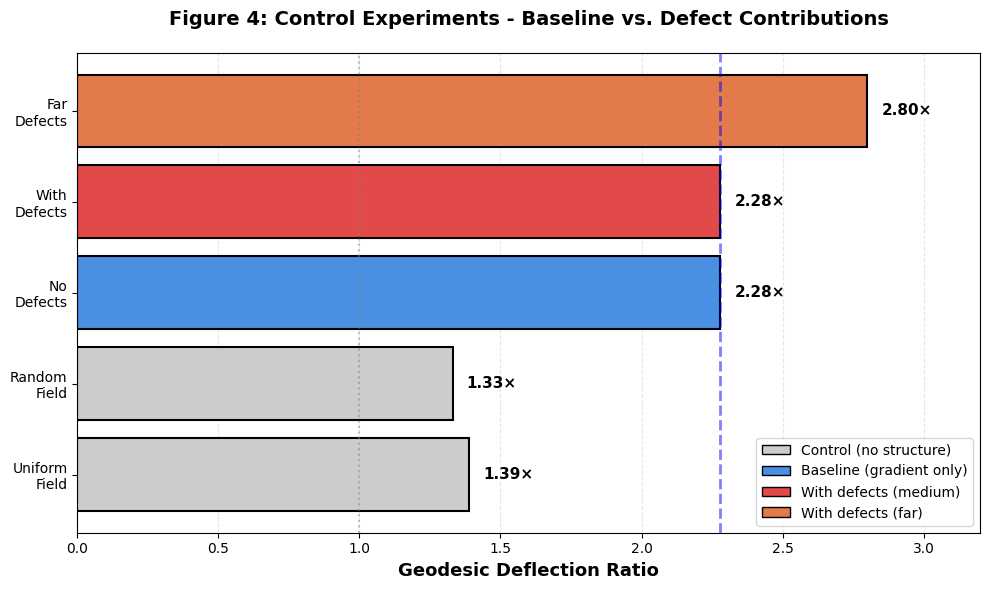

✓ Figure 4 saved: figure4_controls.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# FIGURE 4: Control Experiments
# ============================================================================

print("Generating Figure 4: Control Experiments...")

# Data from your control runs
configs = [
    'Uniform\nField',
    'Random\nField',
    'No\nDefects',
    'With\nDefects',
    'Far\nDefects'
]

deflections = [1.39, 1.33, 2.28, 2.28, 2.80]
colors = ['#cccccc', '#cccccc', '#4a90e2', '#e24a4a', '#e27a4a']

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(configs, deflections, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, deflections)):
    ax.text(val + 0.05, i, f'{val:.2f}×',
           va='center', fontsize=11, fontweight='bold')

# Styling
ax.set_xlabel('Geodesic Deflection Ratio', fontsize=13, fontweight='bold')
ax.set_title('Figure 4: Control Experiments - Baseline vs. Defect Contributions',
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 3.2)
ax.axvline(2.28, color='blue', linestyle='--', linewidth=2, alpha=0.5,
          label='Baseline (no defects)')
ax.axvline(1.0, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Legend
legend_elements = [
    plt.Rectangle((0,0),1,1, fc='#cccccc', ec='black', label='Control (no structure)'),
    plt.Rectangle((0,0),1,1, fc='#4a90e2', ec='black', label='Baseline (gradient only)'),
    plt.Rectangle((0,0),1,1, fc='#e24a4a', ec='black', label='With defects (medium)'),
    plt.Rectangle((0,0),1,1, fc='#e27a4a', ec='black', label='With defects (far)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('figure4_controls.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 4 saved: figure4_controls.png")

# Download file
from google.colab import files
files.download('figure4_controls.png')